### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/6_SentModels

Mounted at /gdrive
/gdrive/My Drive/Progetto AN2DL/6_SentModels


### Import libraries

In [2]:
# Hide warnings
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

import logging

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import pickle
from tqdm import tqdm

### Load and process the dataset

In [5]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save labels in a new list (image pixel values are float in [0, 1])
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5004, 96, 96, 3) (5004,)


In [6]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

# Convert labels in the one-hot encoding format
num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

# Split data into train and val sets
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size=0.1,
    stratify=labels
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4503, 96, 96, 3), y_train shape: (4503, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)


### ConvNeXtLarge

In [7]:
# Import Feature Extractor with specified settings
feature_extractor = tfk.applications.ConvNeXtLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True,
)

785596384/785596384 [==============================] - 9s 0us/step


### Model

In [9]:
# Define network parameters/callbacks
dropout_rate = 1/10
learning_rate = 1e-3

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.999,
    mode='max',
    min_lr=1e-5
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

In [10]:
def build_model(feature_extractor, dropout_rate, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(dropout)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(dropout)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [10]:
model = build_model(feature_extractor, dropout_rate, learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [11]:
train_datagen = ImageDataGenerator(
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        brightness_range=(0.9,1.1),
        fill_mode='reflect')

train_datagen.fit(X_train*255)

In [12]:
history = model.fit_generator(
    train_datagen.flow(X_train*255, y_train, batch_size=16),
    epochs=200,
    steps_per_epoch=len(X_train)/16,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
    ).history

Epoch 1/200
281/281 [==============================] - 58s 111ms/step - loss: 0.5326 - accuracy: 0.7499 - val_loss: 0.3482 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 2/200
281/281 [==============================] - 19s 67ms/step - loss: 0.4003 - accuracy: 0.8217 - val_loss: 0.3319 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 3/200
281/281 [==============================] - 19s 67ms/step - loss: 0.3453 - accuracy: 0.8479 - val_loss: 0.2755 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 4/200
281/281 [==============================] - 19s 66ms/step - loss: 0.3257 - accuracy: 0.8568 - val_loss: 0.2735 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 5/200
281/281 [==============================] - 19s 66ms/step - loss: 0.2982 - accuracy: 0.8719 - val_loss: 0.2570 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 6/200
281/281 [==============================] - 18s 65ms/step - loss: 0.2995 - accuracy: 0.8623 - val_loss: 0.2743 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 7/200
281/281 [==============================

In [13]:
# Save the model
model.save('5thSubmission')
with open('5thSubmission/history.pkl', 'wb') as f:
  pickle.dump(history, f)

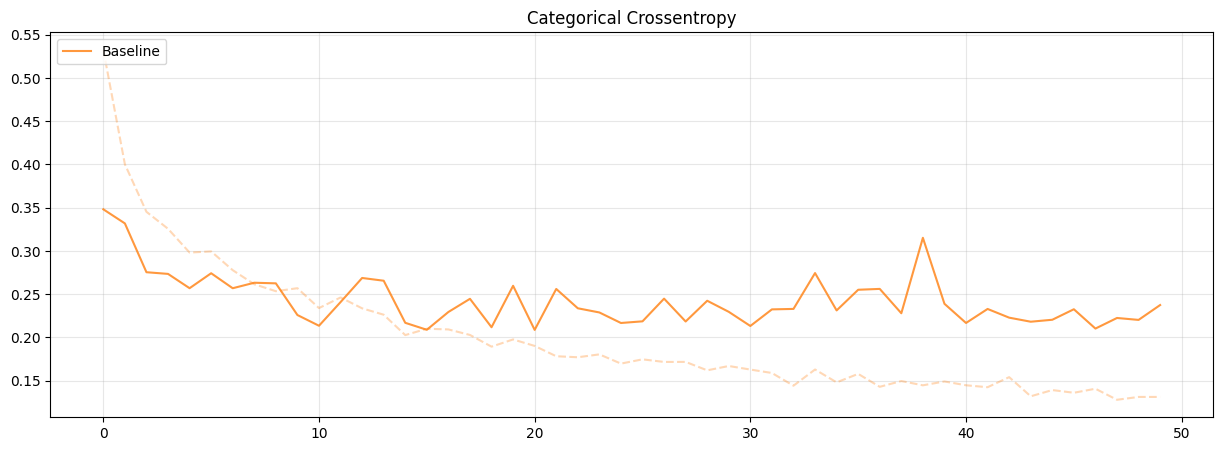

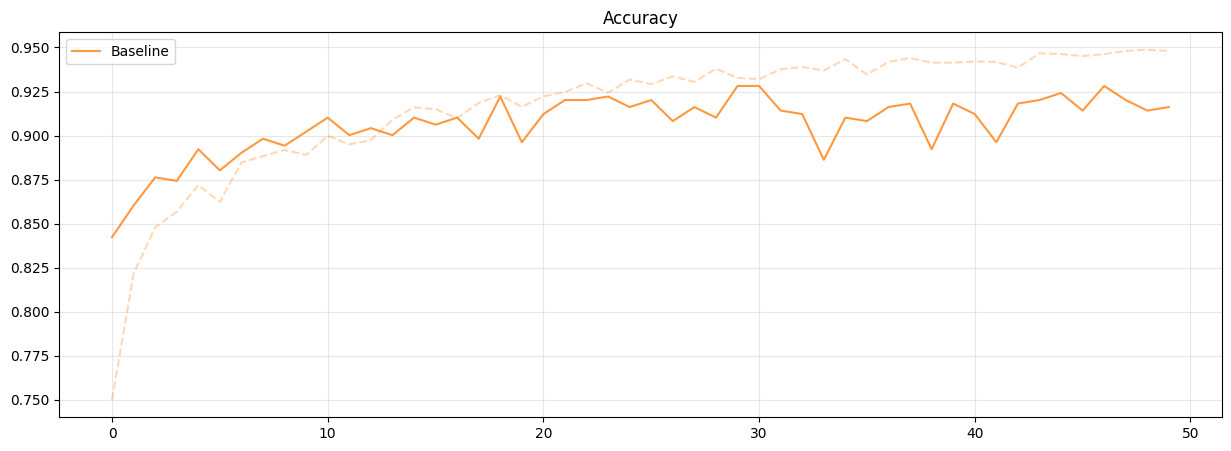

In [14]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Fine Tuning

In [11]:
# Perform Fine Tuning
final_model = tfk.models.load_model('5thSubmission')

train_datagen = ImageDataGenerator(
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        brightness_range=(0.9,1.1),
        fill_mode='reflect')

train_datagen.fit(X_train*255)

# Set all ConvNeXtLarge layers as trainable
final_model.get_layer('convnext_large').trainable = True
for i, layer in enumerate(final_model.get_layer('convnext_large').layers):
  print(i, layer.name, layer.trainable)

# Freeze first N layers, e.g., until the 133rd one
N = 286
for i, layer in enumerate(final_model.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(final_model.get_layer('convnext_large').layers):
  print(i, layer.name, layer.trainable)
final_model.summary()

# Compile the model
final_model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics='accuracy')

# Train the final model on the combined training and validation data
final_history = final_model.fit_generator(
      train_datagen.flow(X_train*255, y_train, batch_size=16),
      epochs=200,
      steps_per_epoch=len(X_train)/16,
      validation_data = (X_val*255, y_val),
      callbacks = [early_stopping, lr_scheduler]
      ).history

0 input_1 True
1 convnext_large_prestem_normalization True
2 convnext_large_stem True
3 convnext_large_stage_0_block_0_depthwise_conv True
4 convnext_large_stage_0_block_0_layernorm True
5 convnext_large_stage_0_block_0_pointwise_conv_1 True
6 convnext_large_stage_0_block_0_gelu True
7 convnext_large_stage_0_block_0_pointwise_conv_2 True
8 convnext_large_stage_0_block_0_layer_scale True
9 convnext_large_stage_0_block_0_identity True
10 tf.__operators__.add True
11 convnext_large_stage_0_block_1_depthwise_conv True
12 convnext_large_stage_0_block_1_layernorm True
13 convnext_large_stage_0_block_1_pointwise_conv_1 True
14 convnext_large_stage_0_block_1_gelu True
15 convnext_large_stage_0_block_1_pointwise_conv_2 True
16 convnext_large_stage_0_block_1_layer_scale True
17 convnext_large_stage_0_block_1_identity True
18 tf.__operators__.add_1 True
19 convnext_large_stage_0_block_2_depthwise_conv True
20 convnext_large_stage_0_block_2_layernorm True
21 convnext_large_stage_0_block_2_pointwis

In [12]:
# Save the model
final_model.save('5thSubmission_FT')
with open('5thSubmission_FT/history.pkl', 'wb') as f:
  pickle.dump(final_history, f)

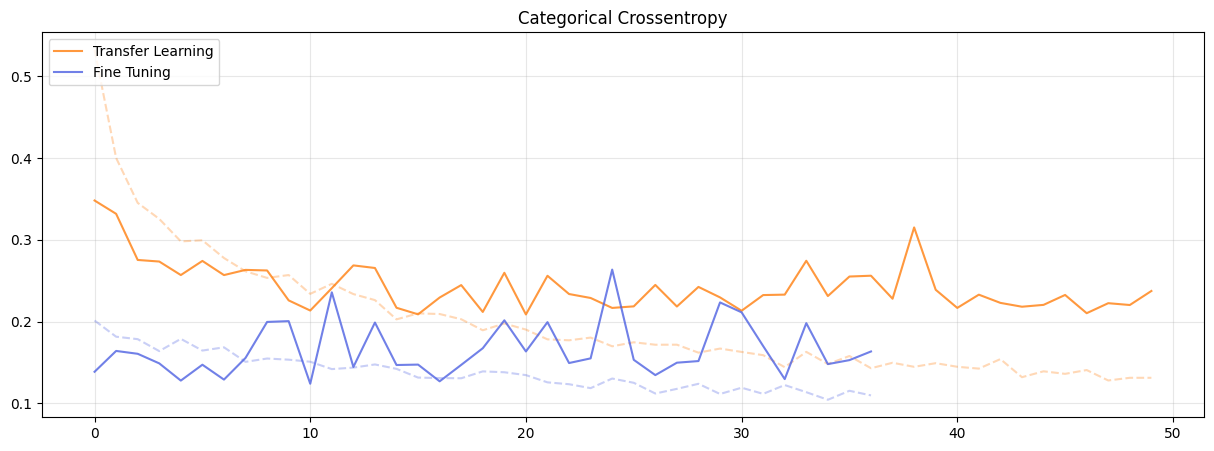

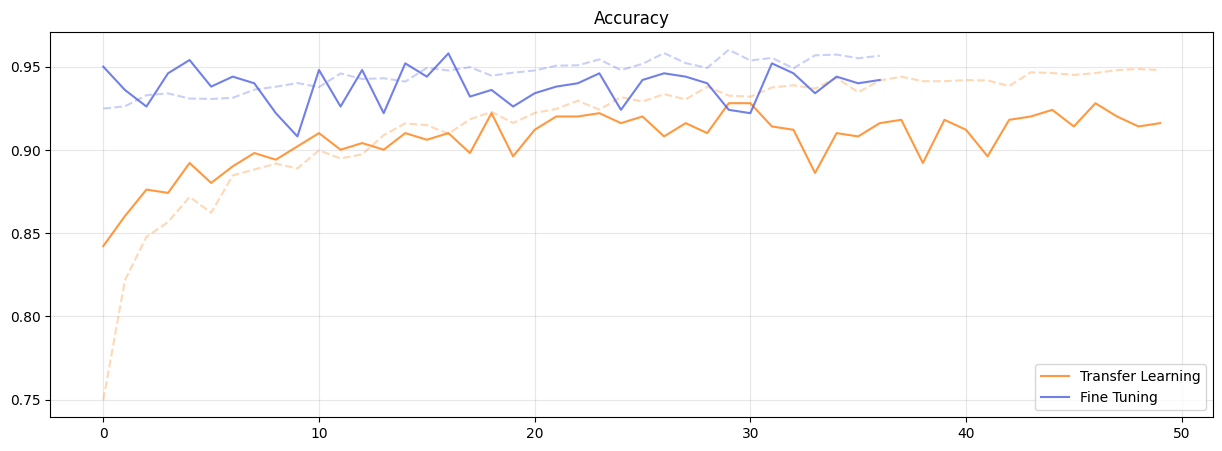

In [13]:
with open('5thSubmission/history.pkl', 'rb') as f:
  history = pickle.load(f)

plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#ff7f0e')
plt.plot(final_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(final_history['val_loss'], label='Fine Tuning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#ff7f0e')
plt.plot(final_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(final_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#4D61E2')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()